### Usual Imports

In [1]:
GPU_NUMBER = 3
root = '/data/vision/torralba/health-habits/other/enes/'

%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import random
import json
import math
import scipy.misc
import ujson, gzip
sys.path.append( root + 'Utils/')

import pandas as pd
import numpy as np
import tensorflow as tf

from PIL import Image
from IPython.display import display
from pprint import pprint
from notebook_utils import *
from skimage import color, io

os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_NUMBER);
data_root = '/data/vision/torralba/yusuf/imagenet/data/images/train256/'

import warnings
warnings.filterwarnings('ignore')

### Get the Data

In [2]:
f = gzip.open('/afs/csail.mit.edu/u/k/kocabey/TF_colorization/dataset_indexes/imagenet_train_256_saturation_values.json.gz', 'rt')
saturation_index = ujson.load(f)
len(saturation_index)

1281145

In [3]:
all_paths = [k for (k,v) in saturation_index.items() if v > 0.1]
print len(all_paths)

1178311


### Setup TensorFlow Graph

In [4]:
BATCH_SIZE = 1
from construct_graph import setup_tensorflow_graph, loss_function, get_prediction

image_, output_, output = setup_tensorflow_graph(BATCH_SIZE)
loss = loss_function(output, output_)
prediction = get_prediction(output)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

saver = tf.train.Saver()

### Prepare Batches

In [5]:
quantized_array = np.load('/afs/csail.mit.edu/u/k/kocabey/TF_colorization/notebooks/pts_in_hull.npy')

In [6]:
def gaussian( x, var ):
  return np.exp( -(x**2) / (2 * var**2))

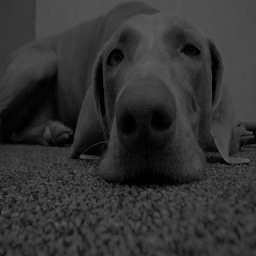

In [7]:
def get_data(path):
  img = io.imread(path)
  resized_img = scipy.misc.imresize(img, (64,64))
  img = color.rgb2lab(img)
  assert img.shape == (256,256,3)
  image = img[:,:,0:1]
  img = color.rgb2lab(resized_img)
  colors = img[:,:,1:3]
  colors = np.tile( colors.reshape((64,64,1,2)), (1,1,313,1))
  big_quantized = np.tile( quantized_array, (64,64,1,1))
  distances = np.linalg.norm(colors - big_quantized, axis = 3)
  d = distances.copy()
  d.sort(axis = 2)
  low_values = (distances > np.tile( d[:,:,4:5], (1,1,313) ))
  gaussian_distances = gaussian(distances, 5)
  gaussian_distances[low_values] = 0
  output = gaussian_distances / np.sum(gaussian_distances, axis = 2).reshape((64,64,1))
  return image, output

image, output = get_data( data_root + all_paths[0] )
Image.fromarray( image.reshape((256,256)).astype(np.uint8))

In [8]:
def get_batch(path_list):
  n = len(path_list)
  batch_image = np.zeros((n,256,256,1))
  batch_output = np.zeros((n,64,64,313))
  
  for i in xrange(n):
    image, output = get_data( data_root + path_list[i] )
    batch_image[i] = image
    batch_output[i] = output
  
  return batch_image, batch_output

### Class Probabilities to Point Estimates

In [9]:
def get_colorized_image( image, prediction ):
  T = 0.38
  epsilon = 1e-8

  annealed_mean = np.exp( np.log(prediction + epsilon) / T ) 
  annealed_mean /= np.sum(annealed_mean, axis = 2).reshape((256,256,1))
  
  predicted_coloring = np.dot(annealed_mean, quantized_array)
  colorized_image = np.zeros( (256,256,3) )
  colorized_image[:,:,0:1] = image
  colorized_image[:,:,1:] = predicted_coloring
  
  return Image.fromarray( (255 * color.lab2rgb(colorized_image)).astype(np.uint8) )

In [10]:
test_images = random.sample( all_paths, BATCH_SIZE)
test_image_batch, test_output_batch = get_batch(test_images)

In [11]:
def colorize_and_save_test_images():
  test_image_predictions = sess.run( prediction,  feed_dict = {image_: test_image_batch} )
  for i in range(len(test_images)):
    get_colorized_image(test_image_batch[i], test_image_predictions[i]).save(str(i) + '.jpg')

### Training

In [12]:
sess = tf.Session()
sess.run( tf.initialize_all_variables())
f = open('log.txt', 'w')

In [ ]:
ITERATIONS = 10000000

for i in xrange(ITERATIONS):
  write(i)
  paths = random.sample( all_paths, BATCH_SIZE )
  image_batch, output_batch = get_batch( paths )
  loss_res, _ = sess.run( [loss,train_step], feed_dict = {image_: image_batch, output_: output_batch})
  f.write(str(loss_res) + '\n'); f.flush()
  
  if i % 1000 == 999: 
    colorize_and_save_test_images()
    saver.save( sess, 'model' )

 11